## eco-velo on simulation

In this notebook we will apply our eco-velo method to a simulation. You can use this notebook to reproduce figures 5B and S7.

In [18]:
### load libraries

# general libraries
import pandas as pd
import numpy as np

# single cell libraries
import scvelo as scv
import scanpy as sc
#import anndata as ad

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for generating a PCA embedding
from sklearn.manifold import TSNE #for generating a t-SNE embedding

#other
from scipy.spatial import cKDTree #for calculating NN
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization

# import our own functions
from functions import *
from projection import *
from simulation import *

In [2]:
### set scvelo settings
scv.settings.verbosity = 0 

### Generate simulation data

Here, we generate the simulation data that we will be using to test our $\kappa$-velo method. The simulation is create using the build in function from scVelo: `scvelo.datasets.simulation`. Our simulation contains 50 genes and 2850 cells. The parameters $\alpha$, $\beta$ and $\gamma$ are sampled from a multivariate log-normal distribution and scaled by a scaling factor $\kappa$ between 1 and 15.

In [3]:
### set seed
np.random.seed(3)

### set variables
n_vars, n_obs, t_max, noise_level = 50, 3000, 10, 1
switches = np.arange(.9, 0.999, (.999-.9)/n_vars)
start_t = None

### set parameters alpha, beta, gamma
mu = np.array([1, .2, .05])
R = np.array([[1., .2, .2], [.2, 1., .2], [.2, .2, 1.]])
C = np.array([0.2, 0.2, 0.2])[:, None]
cov = C.dot(C.T) * R
alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
beta /= 3
gamma /= 3

### scale genes to different time scales (kappa)
max_kappa = 15
min_kappa = 1
kappa = np.random.uniform(min_kappa, max_kappa, n_vars)
kappa[0:3]=1
alpha, beta, gamma, switches = alpha*kappa, beta*kappa, gamma*kappa, switches 

### create simulation dataset
adata = simulation(n_obs=n_obs, t_max=t_max, n_vars=n_vars, noise_level=noise_level, alpha=alpha, beta=beta, gamma=gamma, switches=switches, start_t=start_t)

### remove first 150 cells
adata = adata[0:n_obs-150].copy()
scv.pp.neighbors(adata)

### Find first MNN of u in S

Here, we use the unspliced counts of each cell and match it to the first mutual nearest neighbour (MNN) in the S space. 

In [4]:
### log transformation of the dataset
adata.X = np.matrix(np.where(adata.X != 0, np.log(adata.X), 0))
adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))

In [5]:
### L2 normalize spliced and unspliced separately
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata.layers['spliced'] = sk.preprocessing.normalize(adata.layers['spliced'], norm='l2')
adata.layers['unspliced'] = sk.preprocessing.normalize(adata.layers['unspliced'], norm='l2')

In [6]:
### get spliced and unspliced counts in matrix
mnn = find_mutual_nn(adata.layers['unspliced'], adata.layers['spliced'], k = 100)

### Visualisation of velocities 

Here, we visualise the velocities using eco-velo's approach. We show the approach on PCA, t-SNE, and UMAP embeddings. 

### (I) PCA

In [7]:
### calculate PCA on spliced counts
sc.tl.pca(adata, n_comps=5)

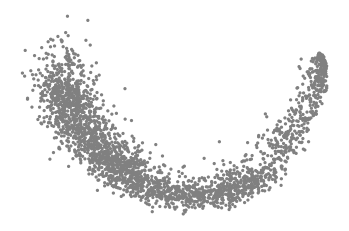

In [8]:
### plot PCA
scv.pl.scatter(adata, "pca")

In [9]:
### get points for PCA
orig_points = adata.obsm["X_pca"]
new_points = orig_points[mnn]
dx = new_points[:,0] - orig_points[:,0]
dy = new_points[:,1] - orig_points[:,1]

In [10]:
### create selection
step = 3
select = np.zeros(adata.shape[0]).astype(bool)
select[np.arange(0, adata.shape[0], step)]=True
select[np.array(mnn)<=0]=False

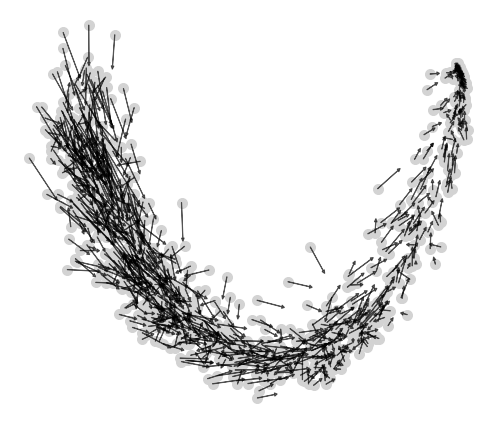

In [12]:
### create PCA plot (eco-velo visualisation)
fig, axs = plt.subplots(1, 1, figsize=(7, 6), frameon=False)

kwargs = {"vmin":0, "vmax":30}
axs.scatter(orig_points[select,0], orig_points[select,1], color="lightgrey",s=100, **kwargs)

n=4
akwargs = {"head_width":.01, "head_length":.01, "alpha":.6, "width":0.001, "color":"black"}
for i in np.where(select)[0]:
    axs.arrow(orig_points[i,0], orig_points[i,1], dx=dx[i]/n, dy=dy[i]/n, **akwargs)

axs.axis('off')
fig.tight_layout()

# save figure
save_path = "../figures/FigS7A_PCA_simulation_eco-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### (II) UMAP

In [13]:
### calculate NN
sc.pp.neighbors(adata, n_neighbors=20, use_rep = "X_pca", n_pcs=5)

### calculate UMAP on spliced counts
sc.tl.umap(adata)

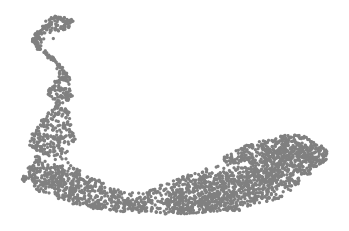

In [14]:
### plot UMAP
scv.pl.scatter(adata, "umap")

In [15]:
### get points for UMAP
orig_points = adata.obsm["X_umap"]
new_points = orig_points[mnn]
dx = new_points[:,0] - orig_points[:,0]
dy = new_points[:,1] - orig_points[:,1]

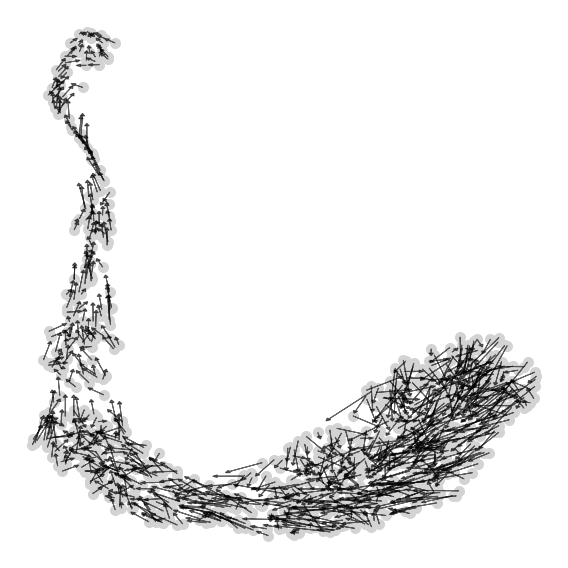

In [16]:
### create UMAP plot (eco-velo visualisation)
fig, axs = plt.subplots(1, 1, figsize=(8, 8), frameon=False)

kwargs = {"vmin":0, "vmax":30}
axs.scatter(orig_points[select,0], orig_points[select,1], 
            color="lightgrey",
            s=100, **kwargs)

akwargs = {"head_width":.15, "head_length":.15, "alpha":.6, "width":0.001, "color":"black"}
for i in np.where(select)[0]:
    axs.arrow(orig_points[i,0], orig_points[i,1], dx=dx[i]/n, dy=dy[i]/n, **akwargs)
    
axs.axis('off')
fig.tight_layout()

# save figure
save_path = "../figures/FigS7B_UMAP_simulation_eco-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### (III) t-SNE

In [19]:
### calculate t-SNE on spliced counts
data = TSNE(n_components=2, random_state=0, perplexity=100).fit_transform(adata.obsm["X_pca"])
data[:,0]=-data[:,0]
adata.obsm["X_tsne"]=data

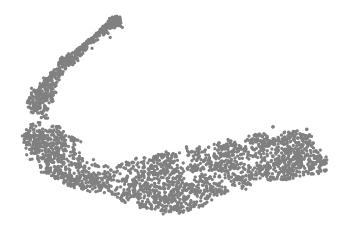

In [20]:
### plot t-SNE
scv.pl.scatter(adata, "tsne")

In [21]:
### get points for t-SNE
orig_points = adata.obsm["X_tsne"]
new_points = orig_points[mnn]
dx = new_points[:,0] - orig_points[:,0]
dy = new_points[:,1] - orig_points[:,1]

In [22]:
### create selection
step = 5
select = np.zeros(adata.shape[0]).astype(bool)
select[np.arange(0, adata.shape[0], step)]=True
select[np.array(mnn)<=0]=False

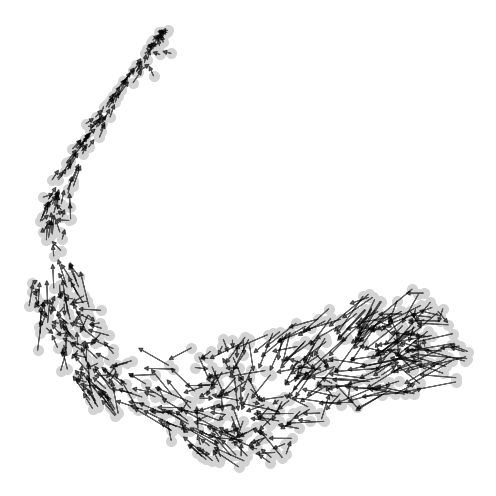

In [23]:
### create t-SNE plot (eco-velo visualisation)
fig, axs = plt.subplots(1, 1, figsize=(7, 7), frameon=False)

kwargs = {"vmin":0, "vmax":30}
akwargs = {"head_width":.6, "head_length":.6, "alpha":.6, "width":0.0001, "color":"black"}

axs.scatter(orig_points[select,0], orig_points[select,1], color="lightgrey", s=100, **kwargs)

for i in np.where(select)[0]:
    axs.arrow(orig_points[i,0], orig_points[i,1], dx=dx[i]/n, dy=dy[i]/n, **akwargs)

axs.axis('off')
fig.tight_layout()

# save figure
save_path = "../figures/Fig5B_tSNE_simulation_eco-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()